In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, KFold
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score, precision_score, recall_score
import seaborn as sns
import shap
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AdamW
import torch
from wordcloud import WordCloud

In [3]:
# Load dataset
df = pd.read_csv('/content/sample_data/twinviews-13k.csv')

# Display basic information and head
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13855 entries, 0 to 13854
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   left    13855 non-null  object
 1   right   13855 non-null  object
 2   topic   13855 non-null  object
dtypes: object(3)
memory usage: 324.9+ KB


,left,right,topic
0,LGBTQ+ individuals should have the same rights...,Marriage should only be between a man and a wo...,LGBTQ+ Rights
1,Police reform is necessary to address systemic...,Law enforcement should be supported and given ...,Police Reform
2,A woman should have the right to choose whethe...,Abortion should be illegal and considered as t...,Abortion Rights
3,Increase regulations on businesses to protect ...,Reduce regulations on businesses to promote in...,Regulation
4,Investing in clean energy technologies will cr...,Government subsidies for clean energy distort ...,Clean Energy


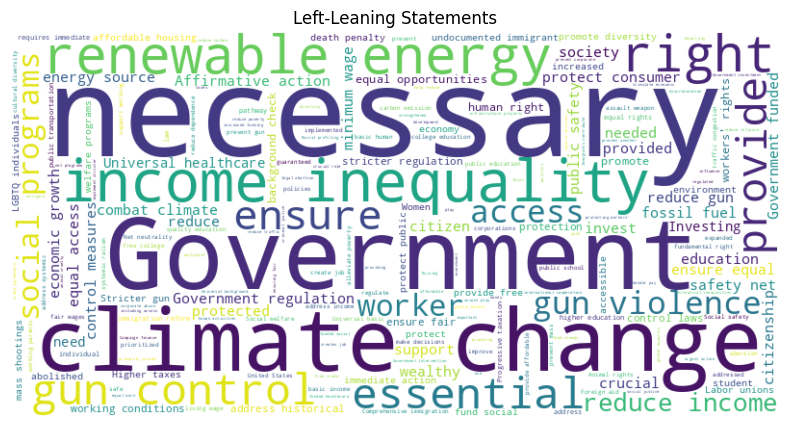

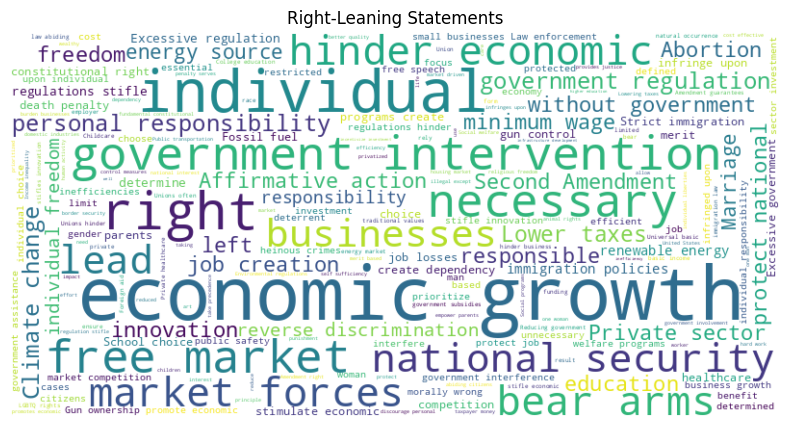

In [4]:
def generate_word_cloud(data, column, title):
    text = ' '.join(data[column].tolist())
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

# Word cloud for left-leaning statements
generate_word_cloud(df, 'left', 'Left-Leaning Statements')

# Word cloud for right-leaning statements
generate_word_cloud(df, 'right', 'Right-Leaning Statements')

In [5]:
# Create a DataFrame for left-leaning statements with label 0
left_df = df[['left', 'topic']].rename(columns={'left': 'text'})
left_df['label'] = 0

# Create a DataFrame for right-leaning statements with label 1
right_df = df[['right', 'topic']].rename(columns={'right': 'text'})
right_df['label'] = 1

# Concatenate left and right DataFrames
stance_df = pd.concat([left_df, right_df], ignore_index=True)

# Display the first few rows of the transformed DataFrame
stance_df.head()

,text,topic,label
0,LGBTQ+ individuals should have the same rights...,LGBTQ+ Rights,0
1,Police reform is necessary to address systemic...,Police Reform,0
2,A woman should have the right to choose whethe...,Abortion Rights,0
3,Increase regulations on businesses to protect ...,Regulation,0
4,Investing in clean energy technologies will cr...,Clean Energy,0


In [6]:
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(stance_df['text'], stance_df['label'], test_size=0.2, random_state=42)

# Load the tokenizer for DistilBERT
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

# Tokenize the text data with reduced max_length
def tokenize_data(texts, tokenizer, max_length=64):
    return tokenizer(list(texts), padding=True, truncation=True, max_length=max_length, return_tensors="pt")

train_encodings = tokenize_data(X_train, tokenizer)
test_encodings = tokenize_data(X_test, tokenizer)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [21]:
# Dataset class
class StanceDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

train_dataset = StanceDataset(train_encodings, y_train.tolist())
test_dataset = StanceDataset(test_encodings, y_test.tolist())


In [22]:
# Load DistilBERT model with sequence classification head
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Define training arguments with fp16 for mixed-precision training and other optimizations
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=1,                     # Single epoch for initial run
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    gradient_accumulation_steps=4,          # Simulates larger batch size
    warmup_steps=500,
    weight_decay=0.01,
    logging_dir='./logs',
    eval_strategy="epoch",
    fp16=True                               # Mixed-precision training for faster performance
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset
)

# Train the model
trainer.train()

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
0,0.220600,0.060260


TrainOutput(global_step=692, training_loss=0.178008669373617, metrics={'train_runtime': 6378.4425, 'train_samples_per_second': 3.475, 'train_steps_per_second': 0.108, 'total_flos': 246356244650496.0, 'train_loss': 0.178008669373617, 'epoch': 0.9989173583543847})

In [23]:
# Evaluate the model
trainer.evaluate()

# Get predictions
predictions = trainer.predict(test_dataset)
preds = predictions.predictions.argmax(axis=1)

# Calculate classification metrics
from sklearn.metrics import classification_report
print(classification_report(y_test, preds))

              precision    recall  f1-score   support

           0       0.98      0.99      0.98      2761
           1       0.99      0.98      0.98      2781

    accuracy                           0.98      5542
   macro avg       0.98      0.98      0.98      5542
weighted avg       0.98      0.98      0.98      5542



In [7]:
import shap
import numpy as np
import torch
from transformers import DistilBertForSequenceClassification, DistilBertTokenizer

# Get the tokenizer and model setup from your previous code
# tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# Select a sample of texts for SHAP explanations
sample_texts = X_test[:20]  # Choose a smaller sample for explanation due to resource intensity

# Tokenize the sample texts
sample_encodings = tokenize_data(sample_texts, tokenizer)

# Define a wrapper function for SHAP that runs on CPU
def model_predict(inputs):
    # Convert inputs to PyTorch tensor for CPU
    inputs = {'input_ids': torch.tensor(inputs)}
    with torch.no_grad():
        outputs = model(**inputs)
    return torch.softmax(outputs.logits, dim=1).numpy()  # Return probabilities as a NumPy array


# Convert the input_ids to a NumPy array for SHAP
background_data = sample_encodings['input_ids'].cpu().numpy() if sample_encodings['input_ids'].is_cuda else sample_encodings['input_ids'].numpy()

# Use KernelExplainer for SHAP
explainer = shap.KernelExplainer(model_predict, background_data)

# Calculate SHAP values
shap_values = explainer.shap_values(background_data)

# Plot SHAP values for a specific instance
shap.initjs()
shap.force_plot(explainer.expected_value[1], shap_values[1][0], sample_texts.iloc[0])


Provided model function fails when applied to the provided data set.


NameError: name 'model' is not defined